In [1]:
import os, shutil, warnings, torch
import pandas as pd

import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, F1Score
from torch.utils.data import DataLoader, TensorDataset

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

In [2]:
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

warnings.filterwarnings("ignore")

ds_folder = r'C:\Users\parvs\VSC Codes\Python-root\_Projects_Personal\mindEase_v2\datasets\Conversational Training\Intent Based\difDs'

trainfile = os.path.join(ds_folder, 'train.csv')
validfile = os.path.join(ds_folder, 'val.csv')
testfile = os.path.join(ds_folder, 'test.csv')

traindf = pd.read_csv(trainfile)
validdf = pd.read_csv(validfile)
testdf = pd.read_csv(testfile)

In [3]:
model_name = "distilbert/distilbert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_name)

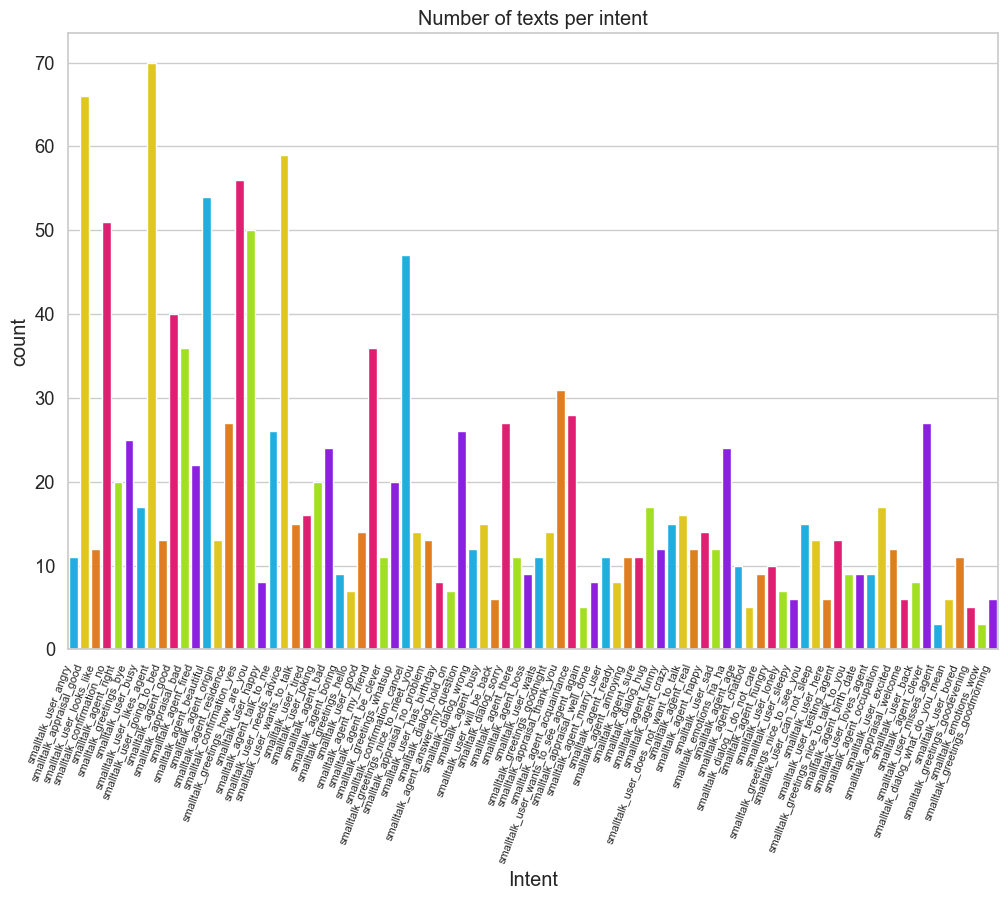

In [4]:
trainfeatures = traindf.copy()
trainlabels = trainfeatures.pop("Intent")

testfeatures = testdf.copy()
testlabels = testfeatures.pop("Intent")

validfeatures = validdf.copy()
validlabels = validfeatures.pop("Intent")

chart = sns.countplot(x=trainlabels, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=69, horizontalalignment='right', fontsize=8)

# Get the x-axis entries
x_axis_entries = [tick.get_text() for tick in chart.get_xticklabels()]
len_dims = len(x_axis_entries)

In [5]:
label_encoder = LabelEncoder()

trainlabels = label_encoder.fit_transform(trainlabels.values)
testlabels = label_encoder.transform(testlabels.values)
validlabels = label_encoder.transform(validlabels.values)

In [6]:
class IntentClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(IntentClassifier, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.logits

num_labels = len_dims
model = IntentClassifier(model_name, num_labels).to('cuda')

def prepare_data(features, labels):
    features = [str(feature) for feature in features]
    features = tokenizer(features, padding=True, truncation=True, return_tensors="pt")
    
    labels = torch.tensor(labels).long().to('cuda')  # Change to long tensor
    
    dataset = TensorDataset(features['input_ids'], features['attention_mask'], labels)
    return dataset

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
epochs = 5

# Prepare train, validation, and test datasets
train_dataset = prepare_data(trainfeatures.values, trainlabels)
valid_dataset = prepare_data(validfeatures.values, validlabels)
test_dataset = prepare_data(testfeatures.values, testlabels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# loss_fn = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for multi-label classification
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

# accuracy = Accuracy(task='binary').to('cuda') 
accuracy = Accuracy(task='multiclass', num_classes=num_labels, average='micro').to('cuda') 
f1_score = F1Score(task="multilabel", num_labels=num_labels, average='micro').to('cuda')

In [8]:
model.cuda()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_accuracy = 0
    total_f1 = 0 

    for batch in train_loader:

        input_ids, attention_mask, labels = [x.to('cuda') for x in batch] 
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        total_accuracy += accuracy(logits, labels)
        total_f1 += f1_score(logits, labels)

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)
    avg_f1 = total_f1 / len(train_loader)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Training loss: {avg_loss:.4f}, Training accuracy: {avg_accuracy:.4f}, Training F1: {avg_f1:.4f}")

model.eval()
total_val_loss = 0
total_val_accuracy = 0
total_val_f1 = 0

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = [x.to('cuda') for x in batch]

        logits = model(input_ids, attention_mask=attention_mask)

        val_loss = loss_fn(logits, labels)
        total_val_loss += val_loss.item()
        total_val_accuracy += accuracy(logits, labels)
        total_val_f1 += f1_score(logits, labels)

avg_val_loss = total_val_loss / len(valid_loader)
avg_val_accuracy = total_val_accuracy / len(valid_loader)
avg_val_f1 = total_val_f1 / len(valid_loader)

print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {avg_val_accuracy:.4f}, Validation F1: {avg_val_f1:.4f}")

RuntimeError: Predictions and targets are expected to have the same shape, but got torch.Size([32, 84]) and torch.Size([32]).

In [ ]:
# Testing the Model
model.eval()
total_test_loss = 0
total_test_accuracy = 0
total_test_f1 = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to('cuda') for x in batch]

        logits = model(input_ids, attention_mask=attention_mask)

        test_loss = loss_fn(logits, labels)
        total_test_loss += test_loss.item()
        total_test_accuracy += accuracy(logits, labels)
        total_test_f1 += f1_score(logits, labels)

avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader)
avg_test_f1 = total_test_f1 / len(test_loader)

print(f"Test loss: {avg_test_loss:.4f}, Test accuracy: {avg_test_accuracy:.4f}, Test F1: {avg_test_f1:.4f}")